# **TASK - 3: IMAGE CAPTIONING**
Combine computer vision and natural language processing to build an image captioning AI. Use pre-trained image recognition models like VGG or ResNet to extract features from images, and then use a recurrent neural network (RNN) or transformer-based model to generate captions for those images.

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Extracting image features (this may take ~1 minute)...
Training model (quick version)...
Epoch 1/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 381ms/step - loss: 3.2208 - val_loss: 3.1350
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 0.0218 - val_loss: 6.1043


✅ Model saved as image_captioning_model_quick.h5
🖼️ Image: /content/drive/MyDrive/Colab Notebooks/Task_3_Image_Caption/Images/2363006088_b3e3aa5c0b.jpg
📝 Generated Caption: <start>


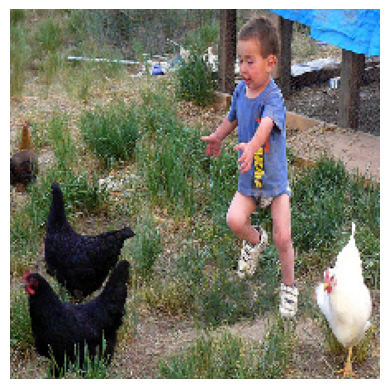

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences, to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Embedding, LSTM, Add, Input
from sklearn.model_selection import train_test_split
import os
import random

# --- PATHS ---
image_folder_path = '/content/drive/MyDrive/Colab Notebooks/Task_3_Image_Caption/Images'
caption_file_path = '/content/drive/MyDrive/Colab Notebooks/Task_3_Image_Caption/captions.txt'

# --- LOAD CAPTIONS ---
captions = {}
with open(caption_file_path, 'r') as f:
    for line in f:
        if ',' in line:
            image_filename, caption = line.strip().split(',', 1)
            captions[image_filename.strip()] = caption.strip()

# --- USE ONLY A SMALL SAMPLE (FAST TRAINING) ---
all_files = list(captions.keys())
sample_files = random.sample(all_files, min(30, len(all_files)))  # only 30 samples

images, captions_list = [], []
for filename in sample_files:
    path = os.path.join(image_folder_path, filename)
    if os.path.exists(path):
        images.append(path)
        captions_list.append(captions[filename])

# --- TOKENIZATION ---
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions_list)
vocab_size = len(tokenizer.word_index) + 1
sequences = tokenizer.texts_to_sequences(captions_list)
max_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

# --- FEATURE EXTRACTION (USE SMALL RESNET) ---
def extract_features(images):
    base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
    features = []
    for img in images:
        image = load_img(img, target_size=(224, 224))
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)
        image = tf.keras.applications.resnet50.preprocess_input(image)
        feature = base_model.predict(image, verbose=0)
        features.append(feature.flatten())
    return np.array(features)

print("Extracting image features (this may take ~1 minute)...")
image_features = extract_features(images)

# --- TRAIN/VAL SPLIT ---
X1_train, X1_val, X2_train, X2_val = train_test_split(image_features, padded_sequences, test_size=0.2, random_state=42)

# --- MODEL DEFINITION (SMALLER DIMENSIONS) ---
def define_model(vocab_size, max_length):
    input1 = Input(shape=(2048,))
    fe1 = Dense(128, activation='relu')(input1)

    input2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 128, mask_zero=True)(input2)
    se2 = LSTM(128)(se1)

    decoder1 = Add()([fe1, se2])
    decoder2 = Dense(128, activation='relu')(decoder1)
    output = Dense(vocab_size, activation='softmax')(decoder2)

    model = Model(inputs=[input1, input2], outputs=output)
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
    return model

model = define_model(vocab_size, max_length)

# --- PREPARE OUTPUTS PROPERLY ---
# Use last word in sequence as target (for quick demo)
y_train = np.array([seq[-1] for seq in X2_train])  # last word only
y_val = np.array([seq[-1] for seq in X2_val])

# --- TRAIN QUICKLY (FEW EPOCHS) ---
print("Training model (quick version)...")
model.fit(
    [X1_train, X2_train], y_train,
    epochs=2,
    batch_size=4,
    validation_data=([X1_val, X2_val], y_val),
    verbose=1
)

# --- SAVE MODEL ---
model.save('image_captioning_model_quick.h5')
print("✅ Model saved as image_captioning_model_quick.h5")

# --- CAPTION GENERATION ---
def generate_caption(model, tokenizer, photo, max_length):
    in_text = '<start>'
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat)
        if word is None or word == '<end>':
            break
        in_text += ' ' + word
    return in_text


# --- TEST CAPTION ---
new_image_path = random.choice(images)
photo = extract_features([new_image_path])
caption = generate_caption(model, tokenizer, photo, max_length)
print("🖼️ Image:", new_image_path)
print("📝 Generated Caption:", caption)

# --- DISPLAY IMAGE ---
img = load_img(new_image_path, target_size=(224, 224))
plt.imshow(img)
plt.axis('off')
plt.show()
